### Implement pairs trading strategy using Kalman filter and perform backtesting to evaluate performance

##### Fetching historical stock price data about ADBE and MSFT

In [31]:
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

import matplotlib.pyplot as plt
import numpy as np
from numpy import log, polyfit, sqrt, std, subtract

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [32]:
tickers = ['ADBE', 'MSFT']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2017,12,29)
df = yf.download(tickers, start, end)['Close']


trainS1 = df['ADBE']
trainS2 = df['MSFT']

df.tail(3)

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2017-12-26,174.440002,85.400002
2017-12-27,175.360001,85.709999
2017-12-28,175.550003,85.720001


Finding cointegration, non-stationarity and hurst test

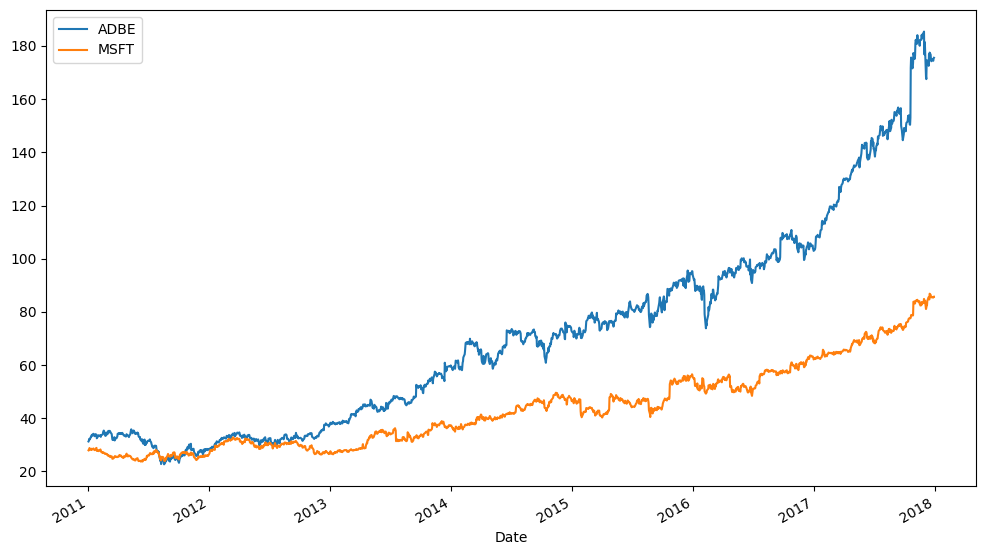

In [33]:
plt.figure(figsize=(12,7))
trainS1.plot()
trainS2.plot()
plt.legend()

In [34]:
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm

In [35]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

stationarity_test(trainS1)
stationarity_test(trainS2)


p-value = 0.9985193058981321 The series ADBE is likely non-stationary.
p-value = 0.9955121924663923 The series MSFT is likely non-stationary.


The individual series are not stationary

In [36]:

result = coint(trainS1, trainS2)
score_coint = result[0]
p_value_coint = result[1]
if p_value_coint<0.05:
    print('Stocks are highly cointegrated with P-value of '+str(p_value_coint))
else:
    print('No cointegration')

Stocks are highly cointegrated with P-value of 0.0007761066902514347


Pretty minimal P-value = 0.00077 so high cointegration, and the pairs trading fundamentals are applicable

In [37]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print("ADBE hurst constant = "+str(hurst(trainS1.values)))
print("MSFT hurst consatnt = "+str(hurst(trainS2.values)))

ADBE hurst constant = 0.4130172170615505
MSFT hurst consatnt = 0.4056721606982059


### Using Kalman filter

#### Some other function definitions

In [38]:
from pykalman import KalmanFilter

In [39]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

#--------------------------------------------------------------------------------------

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#--------------------------------------------------------------------------------------

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

Assuming transaction fee = 0.12%

In [40]:
def backtest(s1, s2, x, y, entryZ, use_smoothened_series = True ):

    # INPUT:
    # s1: the symbol of contract one
    # s2: the symbol of contract two
    # x: the price series of contract one
    # y: the price series of contract two

    # OUTPUT:
    # df1['cum rets']: cumulative returns in pandas data frame
    # sharpe: sharpe ratio

    # Run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    if use_smoothened_series:
        state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
    else:
        state_means = KalmanFilterRegression(x,y)

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    ##############################################################

    halflife = half_life(df1['spread'])

    ##########################################################

    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()


    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    ##############################################################

    entryZscore = entryZ
    exitZscore = 0

    # Set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad');

    # Set up num units short
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1
    print(df1.index)
    # Transaction cost
    trans = 0.0012
    df1['transaction'] = 0
    for i in range(len(df1)):
        if i!=0 and df1.loc[df1.index[i], 'num units long'] != df1.loc[df1.index[i-1], 'num units long']:
            df1.loc[df1.index[i], 'transaction'] += trans
        
        if i!=0 and df1.loc[df1.index[i], 'num units short'] != df1.loc[df1.index[i-1], 'num units short']:
            df1.loc[df1.index[i], 'transaction'] += trans

    df1['cum transaction'] = df1['transaction'].cumsum()
    df1['net return cum'] = df1['cum rets'] - df1['cum transaction']

    # fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 7))
    # ax[0].plot(df1['transaction'])
    # ax[0].legend(['transaction'])
    # ax[1].plot(df1['num units short'])
    # ax[1].legend(['num units short'])
    # ax[2].plot(df1['num units long'])
    # ax[2].legend(['num units long'])
    # ax[3].plot(df1['zScore'])
    # ax[3].legend(['ZScore'])

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    #############################################################
    # print(df1)
    return df1['cum rets'], sharpe, df1['net return cum'], df1

In [41]:
testStart = datetime.datetime(2018,1,1)
testEnd = datetime.datetime(2018,12,30)

dfTest = yf.download(tickers, testStart, testEnd)['Close']
S1 = dfTest['ADBE']
S2 = dfTest['MSFT']

backtest("ADBE", "MSFT", S1, S2, 1.8 )

[*********************100%***********************]  2 of 2 completed

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)


(Date
 2018-01-02    NaN
 2018-01-03    1.0
 2018-01-04    1.0
 2018-01-05    1.0
 2018-01-08    1.0
              ... 
 2018-12-21    1.0
 2018-12-24    1.0
 2018-12-26    1.0
 2018-12-27    1.0
 2018-12-28    1.0
 Name: cum rets, Length: 250, dtype: float64,
 np.float64(nan),
 Date
 2018-01-02    NaN
 2018-01-03    1.0
 2018-01-04    1.0
 2018-01-05    1.0
 2018-01-08    1.0
              ... 
 2018-12-21    1.0
 2018-12-24    1.0
 2018-12-26    1.0
 2018-12-27    1.0
 2018-12-28    1.0
 Name: net return cum, Length: 250, dtype: float64,
                      y           x        hr    spread    zScore  long entry  \
 Date                                                                           
 2018-01-02   85.949997  177.699997 -0.478179  0.977645       NaN       False   
 2018-01-03   86.349998  181.039993 -0.476467  0.090463       NaN       False   
 2018-01-04   87.110001  183.220001 -0.475203  0.043342       NaN       False   
 2018-01-05   88.190002  185.339996 -0.474640  0.

Analysing the difference in returns as entry Z score is varied

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-14',
               ...
               '2017-12-14', '2017-12-15', '2017-12-18', '2017-12-19',
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-26',
               '2017-12-27', '2017-12-28'],
              dtype='datetime64[ns]', name='Date', length=1760, freq=None)
DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-14',
               ...
               '2017-12-14', '2017-12-15', '2017-12-18', '2017-12-19',
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-26',
               '2017-12-27', '2017-12-28'],
              dtype='datetime64[ns]', name='Date', length=1760, freq=None)
DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',

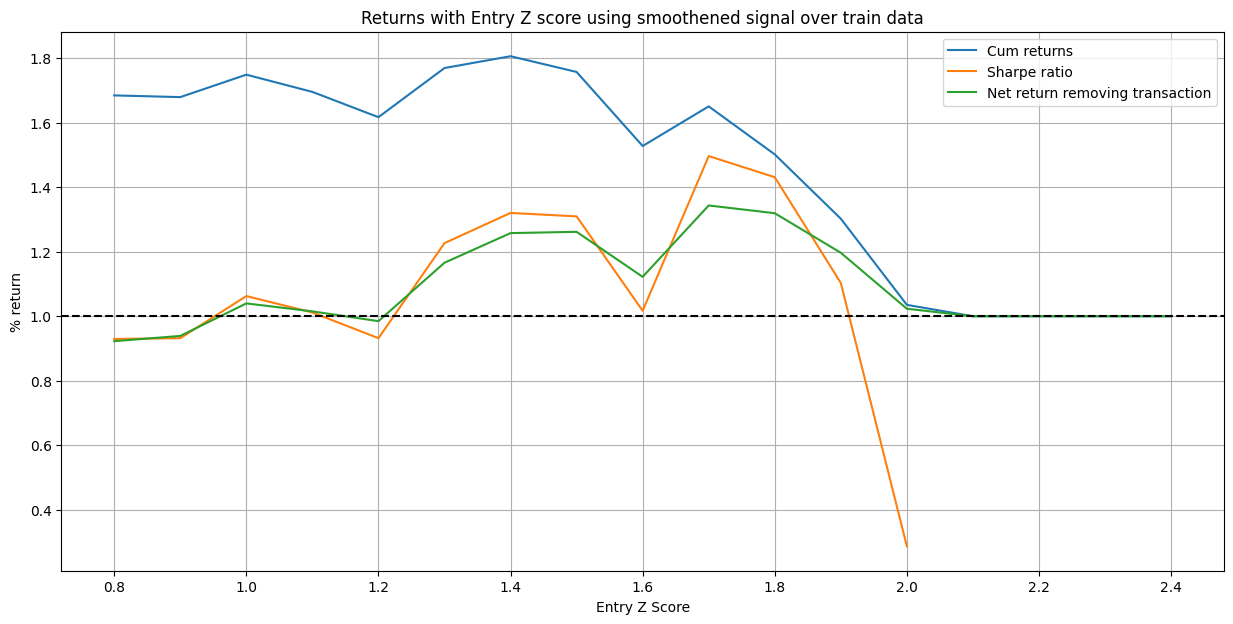

In [42]:
# In sample testing

cum_ret_z_vary_train = []
sharpe_z_vary_train = []
cum_ret_net_train = []
x_zscores = np.arange(0.8,2.5,0.1)
for i in x_zscores:
    cum_ret, sharpe, net, _ = backtest('ADBE', 'MSFT', trainS1, trainS2, i)
    cum_ret_z_vary_train.append(cum_ret[-1])
    sharpe_z_vary_train.append(sharpe)
    cum_ret_net_train.append(net[-1])

plt.figure(figsize=(15,7))
plt.title("Returns with Entry Z score using smoothened signal over train data")
plt.plot(x_zscores, cum_ret_z_vary_train)
plt.plot(x_zscores, sharpe_z_vary_train)
plt.plot(x_zscores, cum_ret_net_train)
plt.xlabel("Entry Z Score")
plt.ylabel(r"% return")
plt.grid()
plt.axhline(1, color='black', linestyle='--')
plt.legend(['Cum returns', 'Sharpe ratio', 'Net return removing transaction'])

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
 

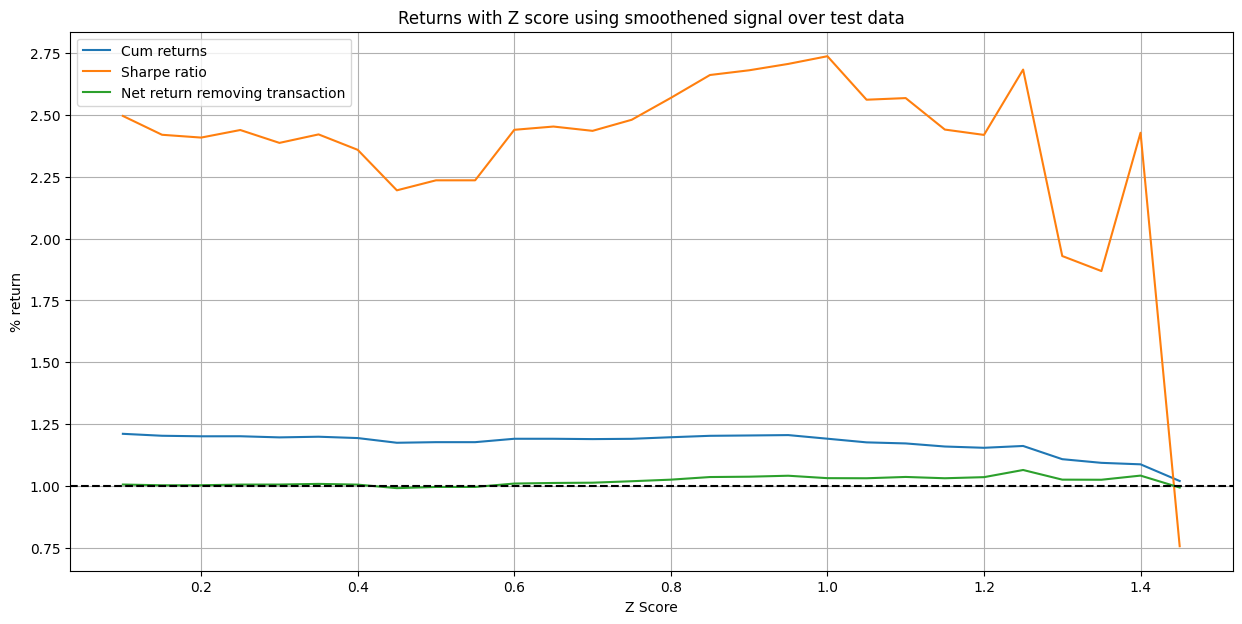

In [43]:
# Out of sample testing

cum_ret_z_vary = []
sharpe_z_vary = []
cum_ret_net = []
x_zscores_new = np.arange(0.1,1.5,0.05)
for i in x_zscores_new:
    cum_ret, sharpe, net, _ = backtest('ADBE', 'MSFT', S1, S2, i)
    cum_ret_z_vary.append(cum_ret[-1])
    sharpe_z_vary.append(sharpe)
    cum_ret_net.append(net[-1])

plt.figure(figsize=(15,7))
plt.title("Returns with Z score using smoothened signal over test data")
plt.plot(x_zscores_new, cum_ret_z_vary)
plt.plot(x_zscores_new, sharpe_z_vary)
plt.plot(x_zscores_new, cum_ret_net)
plt.xlabel("Z Score")
plt.ylabel(r"% return")
plt.grid()
plt.axhline(1, color='black', linestyle='--')
plt.legend(['Cum returns', 'Sharpe ratio', 'Net return removing transaction'])

In [44]:
print("Highest Sharpe ratio is obtained at : Entry Z = "+ str(x_zscores_new[np.nanargmax(sharpe_z_vary)]))
print("Without considering transaction cost : ")
print("Highest profit is obtained at : Entry Z = "+ str(x_zscores_new[np.argmax(cum_ret_z_vary)]))
print("With considering transaction cost : ")
print("Highest profit is obtained at : Entry Z = "+ str(x_zscores_new[np.argmax(cum_ret_net)]))

Highest Sharpe ratio is obtained at : Entry Z = 1.0000000000000004
Without considering transaction cost : 
Highest profit is obtained at : Entry Z = 0.1
With considering transaction cost : 
Highest profit is obtained at : Entry Z = 1.2500000000000004


A significant chunk of portfolio return diminished due to transaction fees. There is a tradeoff.

# Kalman filter without noise removal

In [45]:
cum_ret, sharpe, net, _ = backtest('ADBE', 'MSFT', S1, S2, 1, use_smoothened_series=False)
print(cum_ret)

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
Date
2018-01-02    NaN
2018-01-03    1.0
2018-01-04    1.0
2018-01-05    1.0
2018-01-08    1.0
             ... 
2018-12-21    1.0
2018-12-24    1.0
2018-12-26    1.0
2018-12-27    1.0
2018-12-28    1.0
Name: cum rets, Length: 250, dtype: float64


DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
 

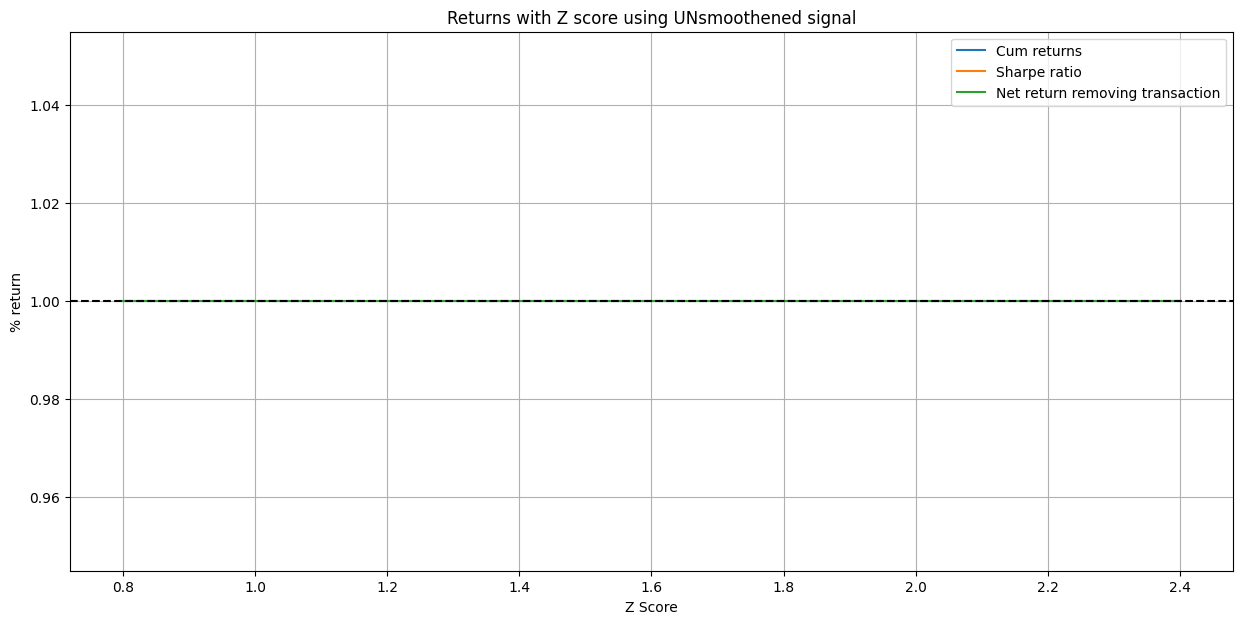

In [46]:

cum_ret_z_vary_unsmooth = []
sharpe_z_vary_unsmooth = []
cum_ret_net_unsmooth = []
for i in np.arange(0.8,2.5,0.1):
    cum_ret, sharpe, net, _ = backtest('ADBE', 'MSFT', S1, S2, i, use_smoothened_series=False)
    cum_ret_z_vary_unsmooth.append(cum_ret[-1])
    sharpe_z_vary_unsmooth.append(sharpe)
    cum_ret_net_unsmooth.append(net[-1])

plt.figure(figsize=(15,7))
plt.title("Returns with Z score using UNsmoothened signal")
print(cum_ret_z_vary_unsmooth)
plt.plot(np.arange(0.8,2.5,0.1), cum_ret_z_vary_unsmooth)
plt.plot(np.arange(0.8,2.5,0.1), sharpe_z_vary_unsmooth)
plt.plot(np.arange(0.8,2.5,0.1), cum_ret_net_unsmooth)
plt.xlabel("Z Score")
plt.ylabel(r"% return")
plt.grid()
plt.axhline(1, color='black', linestyle='--')
plt.legend(['Cum returns', 'Sharpe ratio', 'Net return removing transaction'])



## Finding the reason of No-return in UN smoothened signal

In [47]:
df1 = backtest("ADBE", "MSFT", S1, S2, 1, False)[-1]

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)


1
-1.048000416060842


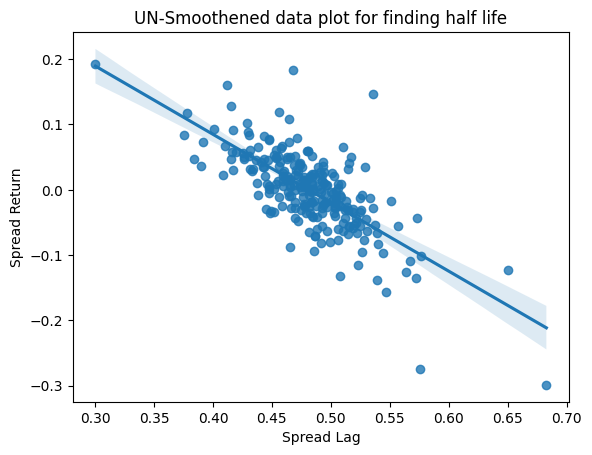

In [49]:
#Smoothened Spread
# plt.plot(df1['spread'])

spread = df1['spread']
spread_lag = spread.shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]

spread_ret = spread - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]

spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret,spread_lag2)
res = model.fit()
halflife = int(round(-np.log(2) / res.params[1],0))

import seaborn as sns 

ax = sns.regplot(x=spread_lag, y=spread_ret)
ax.set_title("UN-Smoothened data plot for finding half life")
ax.set_xlabel('Spread Lag')
ax.set_ylabel('Spread Return')

print(halflife)
print(res.params[1])

1

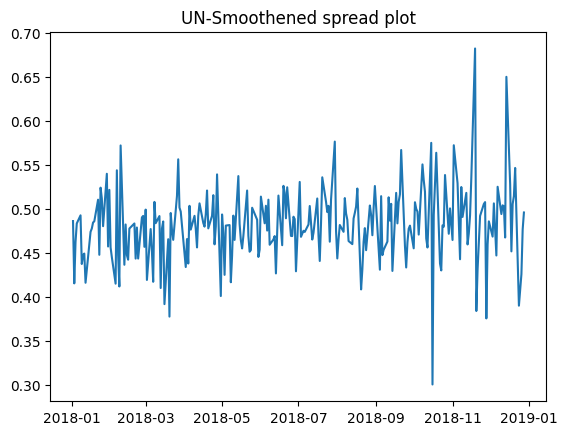

In [50]:
plt.plot(df1['spread'])
plt.title("UN-Smoothened spread plot")
halflife

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=250, freq=None)
4
-0.1666893214581662


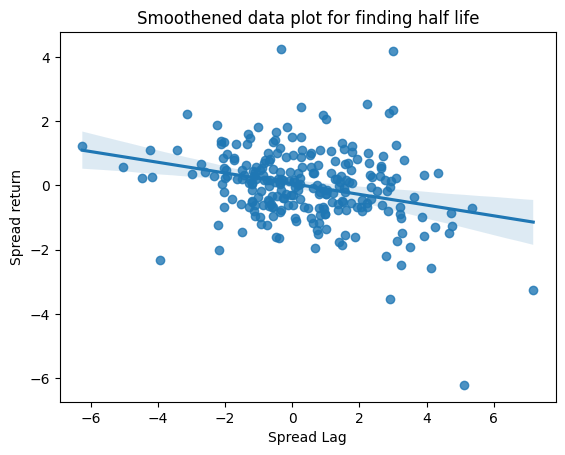

In [51]:
#Smoothened Spread

df1 = backtest("ADBE", "MSFT", S1, S2, 1, True)[-1]


spread = df1['spread']
spread_lag = spread.shift(1)
spread_lag.iloc[0] = spread_lag.iloc[1]

spread_ret = spread - spread_lag
spread_ret.iloc[0] = spread_ret.iloc[1]

spread_lag2 = sm.add_constant(spread_lag)

model = sm.OLS(spread_ret,spread_lag2)
res = model.fit()
halflife = int(round(-np.log(2) / res.params[1],0))

import seaborn as sns 

ax = sns.regplot(x=spread_lag, y=spread_ret)
ax.set_title("Smoothened data plot for finding half life")
ax.set(xlabel='Spread Lag', ylabel='Spread return')

print(halflife)
print(res.params[1])
# halflife

4

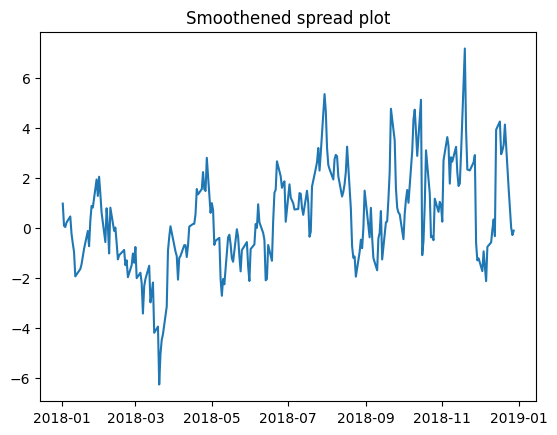

In [52]:
# plt.plot(x)
# plt.plot(y)
# Unsmoothened spread
plt.plot(df1['spread'])
plt.title("Smoothened spread plot")
halflife

As the halflife = 1, the rolling mean = current observation. Hence, Z score = 0.